# Goal

Given information about all user searches within a session, cluster users based on their searching history and identify searches that are likely to happen.

The dataset is in JSON files. Each row includes different cities which have been searched for by a user within the same session, as well as some basic information about users an the cities.


# Data

- session_id : session id. Unique by row
- unix_timestamp : the starting time of the current session
- cities : the cities which were searched for within the same session by a user
- user : 
    - user_id: the id of the user
    - joining_date: when the user created the account
    - country: where the user is based

In [62]:
import pandas as pd
import json
import statistics
import urllib
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')

In [36]:
with open('searche_history.json') as fp:
    data_json = json.load(fp)


In [37]:
print(data_json[:1])

[{'session_id': ['D258NVMV202LS'], 'unix_timestamp': [1442640552], 'cities': ['San Jose CA, Montreal QC'], 'user': [[{'user_id': 5749, 'joining_date': '2015-04-02', 'country': 'FR'}]]}]


In [38]:
# convert the file to a dataframe
data = pandas.DataFrame(columns=["session_id", "timestamp", "cities", "user_id", "joining_date", "country"])

for i in range(len(data_json)):
    data.loc[i, "session_id"]   = data_json[i]["session_id"][0] 
    data.loc[i, "timestamp"]    = data_json[i]["unix_timestamp"][0] 
    data.loc[i, "cities"]       = data_json[i]["cities"][0] 
    data.loc[i, "user_id"]      = data_json[i]["user"][0][0]["user_id"]
    data.loc[i, "joining_date"] = data_json[i]["user"][0][0]["joining_date"]
    data.loc[i, "country"]      = data_json[i]["user"][0][0]["country"]
     


In [39]:
data.head()

,session_id,timestamp,cities,user_id,joining_date,country
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US


In [40]:
data.describe()

,session_id,timestamp,cities,user_id,joining_date,country
count,20022,20022,20022,20022,20022,20022
unique,20022,20001,1293,9252,35,7
top,NFVFA84KGHEBA,1436941314,New York NY,9335,2015-03-14,US
freq,1,2,2296,8,784,3772


In [41]:
data.isna().sum(axis = 0)

session_id      0
timestamp       0
cities          0
user_id         0
joining_date    0
country         0
dtype: int64

In [42]:
data['country'].unique()

array(['FR', 'DE', '', 'US', 'IT', 'UK', 'ES'], dtype=object)

In [43]:
# there are missing values in the country column
data['country'].value_counts()

US    3772
UK    3754
DE    3741
      2769
FR    2341
IT    1843
ES    1802
Name: country, dtype: int64

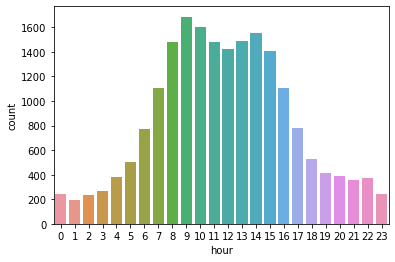

In [44]:
# Overall, peak time is during 7AM-4PM UTC time
data['timestamp']=pandas.to_datetime(data['timestamp'], unit='s')
data['hour']=data['timestamp'].apply(lambda x: x.hour)
sns.countplot(x='hour', data=data)
plt.show()

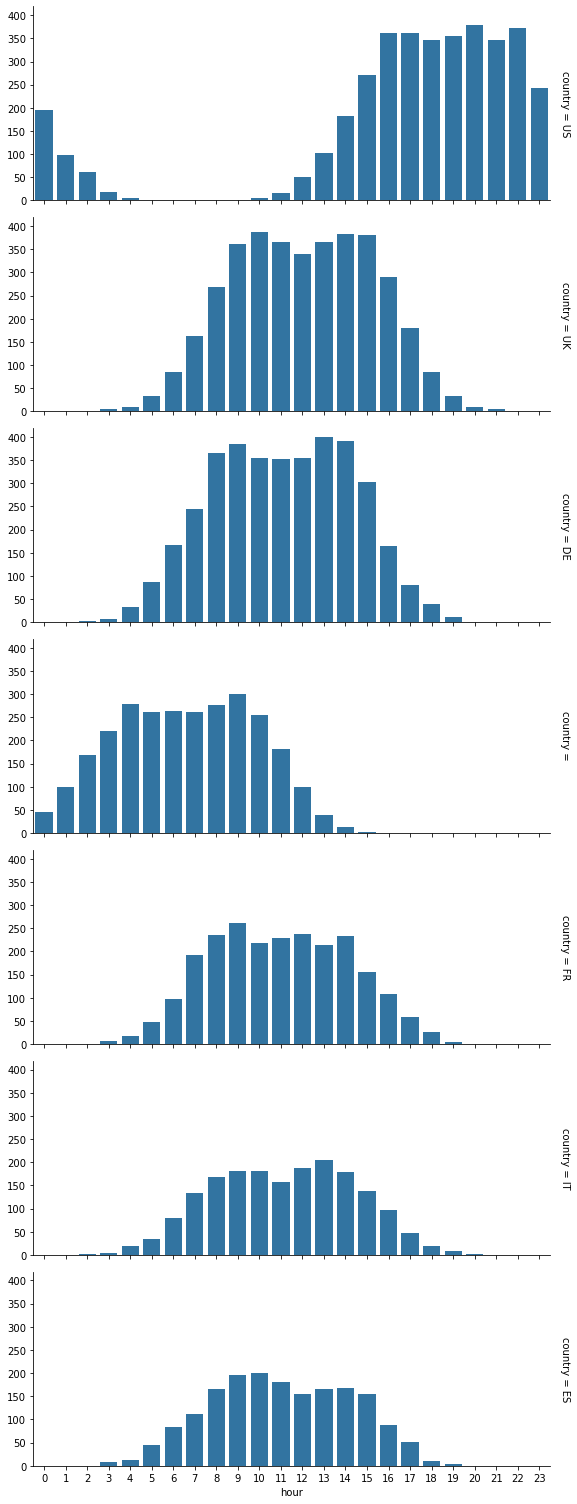

In [45]:
# plot site activity distribution per country and try to guess the time zone based on user activity
g = sns.FacetGrid(data, row="country", row_order=data.country.value_counts().index, margin_titles = True)
g.map(sns.countplot,'hour', order = range(24))
g.fig.set_figwidth(10)
plt.show()

Based on the plot, Western European countries like Germany, Spain, etc. are pretty consistent. The missing country seems to be shifted to the left (aka east) by 4 hours or so. It is most likely a country within the Middle East.

In [46]:
# For each city searched by the user, identify the city which is most likely to be searched within the same session
# create a list of all the searched cities 
cities = data['cities'].str.split(", ")
cities= np.hstack(cities)

In [47]:
cities

array(['San Jose CA', 'Montreal QC', 'New York NY', ..., 'Chicago IL',
       'Los Angeles CA', 'Long Beach CA'], dtype='<U27')

In [48]:
#for each session_id let's get count of cities searched together
count_per_session = data['cities'].apply(lambda x: len(x.split(',')))

In [49]:
count_per_session

0        2
1        1
2        2
3        1
4        2
        ..
20017    1
20018    1
20019    1
20020    1
20021    2
Name: cities, Length: 20022, dtype: int64

In [50]:
#Let's create a vector where each session is repeated as many times as count_per_session
session_id = np.repeat(data['session_id'], count_per_session)

In [51]:
session_id

0        D258NVMV202LS
0        D258NVMV202LS
1        TDG10UKG7I4LR
2        OH4ZDIGN9BLQS
2        OH4ZDIGN9BLQS
             ...      
20018    GQ4W7LU56MHXK
20019    N2FQ84QXOBFQM
20020    54RKP04D2OGDB
20021    HMAKFWT4IV14H
20021    HMAKFWT4IV14H
Name: session_id, Length: 33071, dtype: object

In [52]:
data_similarity = pandas.DataFrame({'cities':cities, 'session_id':session_id})
data_similarity    

,cities,session_id
0,San Jose CA,D258NVMV202LS
0,Montreal QC,D258NVMV202LS
1,New York NY,TDG10UKG7I4LR
2,Montreal QC,OH4ZDIGN9BLQS
2,Quebec QC,OH4ZDIGN9BLQS
...,...,...
20018,OTTAWA ON,GQ4W7LU56MHXK
20019,Indianapolis IN,N2FQ84QXOBFQM
20020,Chicago IL,54RKP04D2OGDB
20021,Los Angeles CA,HMAKFWT4IV14H


In [53]:
#build a similarity matrix, with each row a session, each column a possible city, 
#values 0/1 if that city was searched in that session
data_similarity['binary_value'] = 1
data_similarity = data_similarity.pivot(index='session_id', columns='cities').fillna(0)

print(data_similarity.shape)

(20022, 87)


In [54]:
data_similarity

binary_value                                                   \
cities          Anaheim CA Arlington TX Atlanta GA Austin TX Bakersfield CA   
session_id                                                                    
005DKBSO9FEZL          0.0          0.0        0.0       0.0            0.0   
006EM84U68V9I          0.0          0.0        0.0       0.0            0.0   
009CAJV5IDV7Q          0.0          0.0        0.0       0.0            0.0   
00AR2ULVTS3JY          0.0          0.0        0.0       0.0            0.0   
00B1MRZFC6KZM          0.0          0.0        0.0       0.0            0.0   
...                    ...          ...        ...       ...            ...   
ZZTH5MZ1DY4PX          0.0          0.0        0.0       0.0            0.0   
ZZWVLMEY5H5DM          0.0          0.0        0.0       0.0            0.0   
ZZXKUGEYHZXOJ          0.0          0.0        0.0       0.0            0.0   
ZZYCEP57WDPTC          0.0          0.0        0.0       0.0            0.0   
ZZZ3P5GW1PJWL          0.0          0.0        0.0       0.0            0.0   

                                                                          ...  \
cities        Baltimore MD Birmingham AL Boston MA Buffalo NY Calgary AB  ...   
session_id                                                                ...   
005DKBSO9FEZL          1.0           0.0       0.0        0.0        0.0  ...   
006EM84U68V9I          0.0           0.0       0.0        0.0        0.0  ...   
009CAJV5IDV7Q          0.0           0.0       0.0        0.0        1.0  ...   
00AR2ULVTS3JY          0.0           0.0       0.0        0.0        0.0  ...   
00B1MRZFC6KZM          0.0           0.0       0.0        0.0        0.0  ...   
...                    ...           ...       ...        ...        ...  ...   
ZZTH5MZ1DY4PX          0.0           0.0       0.0        0.0        0.0  ...   
ZZWVLMEY5H5DM          0.0           0.0       0.0        0.0        0.0  ...   
ZZXKUGEYHZXOJ          0.0           0.0       0.0        0.0        0.0  ...   
ZZYCEP57WDPTC          0.0           0.0       0.0        0.0        0.0  ...   
ZZZ3P5GW1PJWL          0.0           0.0       0.0        0.0        0.0  ...   

                                                                    \
cities        Toledo OH Toronto ON Tucson AZ Tulsa OK Vancouver BC   
session_id                                                           
005DKBSO9FEZL       0.0        0.0       0.0      0.0          0.0   
006EM84U68V9I       0.0        0.0       0.0      0.0          0.0   
009CAJV5IDV7Q       0.0        0.0       0.0      0.0          0.0   
00AR2ULVTS3JY       0.0        0.0       0.0      0.0          0.0   
00B1MRZFC6KZM       0.0        0.0       0.0      0.0          0.0   
...                 ...        ...       ...      ...          ...   
ZZTH5MZ1DY4PX       0.0        0.0       0.0      0.0          0.0   
ZZWVLMEY5H5DM       0.0        0.0       0.0      0.0          0.0   
ZZXKUGEYHZXOJ       0.0        0.0       0.0      0.0          0.0   
ZZYCEP57WDPTC       0.0        0.0       0.0      0.0          1.0   
ZZZ3P5GW1PJWL       0.0        0.0       0.0      0.0          0.0   

                                                                      \
cities        Victoria BC Virginia Beach VA WASHINGTON DC Wichita KS   
session_id                                                             
005DKBSO9FEZL         0.0               0.0           0.0        0.0   
006EM84U68V9I         0.0               0.0           0.0        0.0   
009CAJV5IDV7Q         0.0               0.0           0.0        0.0   
00AR2ULVTS3JY         0.0               0.0           0.0        0.0   
00B1MRZFC6KZM         0.0               0.0           0.0        0.0   
...                   ...               ...           ...        ...   
ZZTH5MZ1DY4PX         0.0               0.0           0.0        0.0   
ZZWVLMEY5H5DM         0.0               0.0           0.0        0.0   

In [55]:
from sklearn import metrics

#use cosine similarity
city_cosine = pandas.DataFrame(metrics.pairwise.cosine_similarity(data_similarity.T))

#add index and column names 
city_cosine.columns = data_similarity.columns.get_level_values(1)
city_cosine.index = city_cosine.columns
  
#for each city, find the column with the highest value 
closest_city = pandas.DataFrame({"most_similar_city":[None]*len(city_cosine)})

#Let's have cities as index
closest_city.index = city_cosine.index
  
#For each row, we pick the highest score
i = 0
while i < len(closest_city):
      #for each city, this gives a list of cosine similarity with the other cities
        tmp_cosine = city_cosine.drop(city_cosine.columns[i], axis=1).iloc[i]
      #and now we pick the city with the max
        closest_city.most_similar_city.iloc[i] = tmp_cosine.idxmax()
        i += 1
  



In [56]:
closest_city.head()

,most_similar_city
cities,
Anaheim CA,Santa Ana CA
Arlington TX,Fort Worth TX
Atlanta GA,Birmingham AL
Austin TX,San Antonio TX
Bakersfield CA,Fresno CA


In [ ]:
# cluster user sessions based on travel intent 
# the assumption is that poeple with high intent to travel will search cities close to each other 
# and people with low intent will search random cities 
# first remove searches with just one city, since we don't have enough information 
data_intent = data['cities'][count_per_session>1].reset_index(drop=True)


In [64]:

score = []
i = 0
#loop through all the rows
while i < len(data_intent):
    #find all cities within one session
    cities_intent  = data_intent[i].split(", ")
    #get all pairwise combinations
    cities_combinations = list(itertools.combinations(cities_intent, 2))
    #calculate mean of cosine similarity between those pairs
    pairwise_distance = []
    for j in range(len(cities_combinations)):
          pairwise_distance.append(city_cosine.loc[cities_combinations[j][0], cities_combinations[j][1]])
    score.append(statistics.mean(pairwise_distance))
    i += 1

  


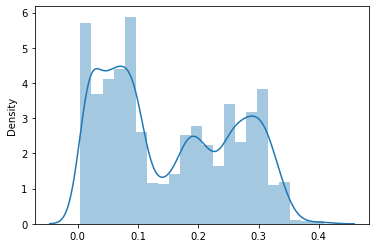

In [65]:
# show average distance distributions 
sns.distplot(score)
plt.show()

In [66]:
print("0.1 represents the ", round(scipy.stats.percentileofscore(score, 0.1), 1), "th ", "percentile", sep="")

0.1 represents the 43.8th percentile


If our assumption is valid and we take 0.1 as threshold, approximately 56% of users are actually planning a trip and 44% of them don’t have high intent to book.